<a href="https://colab.research.google.com/github/Albert-GM/datascience_notebooks/blob/main/card_transacions_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRODUCTION

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Albert-GM/datascience_notebooks/blob/main/card_transacions_covid.ipynb)

In this notebook, I use the data provided by https://opendata-ajuntament.barcelona.cat/es/ , in particular the dataset *2020_Seguiment_COVID19_BCN.csv* that provides a list of indicators to measure the impact of COVID-19 in the city of Barcelona from the fields of health, mortality, meteorology, mobility, prices, labor market, stock market, consumption, housing, opinion and neighbourhood support initiatives, among others. More information about the dataset: https://opendata-ajuntament.barcelona.cat/data/es/dataset/indicadors-covid19-bcn

I analyze the **impact on the market sector of Barcelona of the state of alarm (2020), using data from card transactions**. The data is provided by a spanish bank and there are two fundamental sources:
- Any payment made at the bank's POS.
- Payments made by bank customers at a POS of any other bank.

With this data I try to answer the **following questions using some visualizations** regarding the market sector in the city of Barcelona:

- What has been the impact of the state of alarm?
- How long has it taken for the commercial sector to recover?
- Which commercial sector has been the most affected?



---

*For any questions or suggestions about the code, send me an email to:* albertdavidgil@gmail.com

*Github profile*: https://github.com/Albert-GM

*LinkedIn profile*: https://www.linkedin.com/in/albertgilm/



# SET ENVIRONMENT

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap

plt.style.use('fivethirtyeight')

# GET DATA

In [2]:
df_raw = pd.read_csv("https://raw.githubusercontent.com/Albert-GM/datascience_notebooks/main/datasets/2020_seguiment-covid19-bcn.csv", parse_dates=['Data_Indicador'])
df_raw.head()

,Data_Indicador,Frequencia_Indicador,Territori,Nom_Indicador,Nom_Variable,Valor,Unitat,Font
0,2020-02-26,Diari,Barcelona,Casos de Covid19 a Barcelona,Nombre de casos diaris,0.0,Nombre,Agència de Salut Pública de Barcelona
1,2020-02-27,Diari,Barcelona,Casos de Covid19 a Barcelona,Nombre de casos diaris,0.0,Nombre,Agència de Salut Pública de Barcelona
2,2020-02-28,Diari,Barcelona,Casos de Covid19 a Barcelona,Nombre de casos diaris,0.0,Nombre,Agència de Salut Pública de Barcelona
3,2020-02-29,Diari,Barcelona,Casos de Covid19 a Barcelona,Nombre de casos diaris,0.0,Nombre,Agència de Salut Pública de Barcelona
4,2020-03-01,Diari,Barcelona,Casos de Covid19 a Barcelona,Nombre de casos diaris,0.0,Nombre,Agència de Salut Pública de Barcelona


# EDA

In this section I perform a brief exploratory analysis of the data.

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28651 entries, 0 to 28650
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Data_Indicador        28651 non-null  datetime64[ns]
 1   Frequencia_Indicador  28651 non-null  object        
 2   Territori             28651 non-null  object        
 3   Nom_Indicador         28651 non-null  object        
 4   Nom_Variable          27249 non-null  object        
 5   Valor                 28251 non-null  float64       
 6   Unitat                28651 non-null  object        
 7   Font                  28651 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 1.7+ MB


All the indicators availables in the dataset (in this notebook we will use only one of them):

In [4]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(df_raw['Nom_Indicador'].value_counts())

Població estimada a Barcelona segons franja horària                                                              3013
Compres amb targetes bancaries segons sectors comercials (base 100 = gener 2020)                                 2142
Població estimada a Barcelona segons procedència                                                                 2032
Visitants a Barcelona segons provincia d'origen                                                                  1165
Visitants a Barcelona segons municipi d'origen                                                                   1165
Visitants a Barcelona segons pais d'origen                                                                       1163
Preu aliments a l'engròs: Fruites i hortalisses                                                                  1020
Percentatge de mobilitat de vehicles sobre l'habitual                                                             992
Defuncions registrades a Barcelona                      

Below you can see a quick plot of the indicator *'Shopping with bank cards according to market sectors'*. Notice how the data has a cyclical pattern that seems to repeat itself every week since it can be seen that in each month there are approximately 5 peaks:

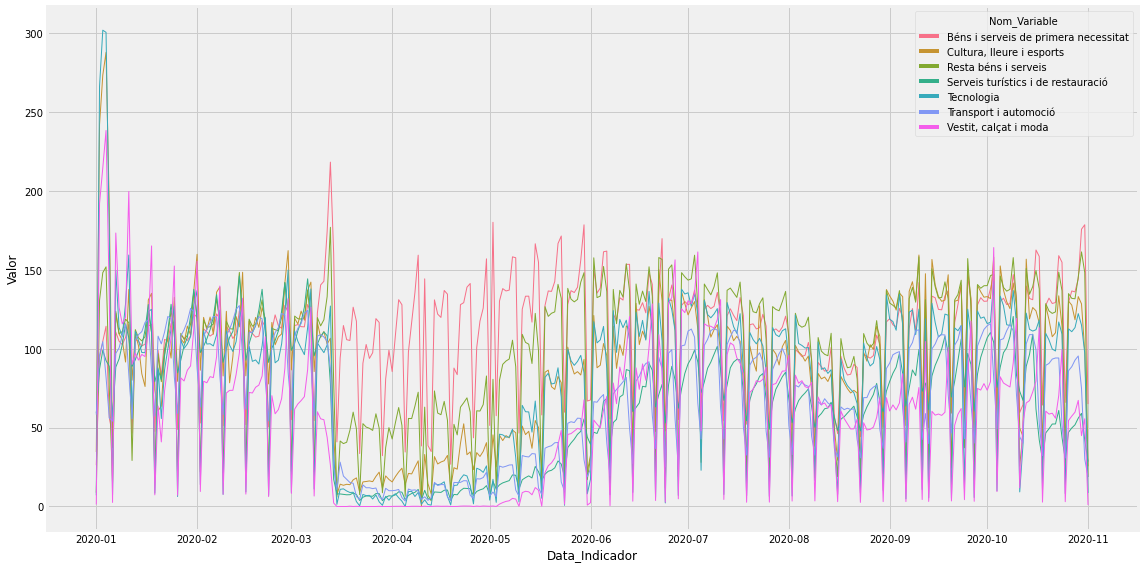

In [5]:
field = 'Compres amb targetes bancaries segons sectors comercials (base 100 = gener 2020)'
df_compres = df_raw.loc[df_raw['Nom_Indicador'] == field]

# plot the figure
fig, ax = plt.subplots(1, 1, figsize = (16,8))
sns.lineplot(data=df_compres, x='Data_Indicador', y='Valor', hue='Nom_Variable',
             linewidth=1)
plt.tight_layout()

# PLOTTING

In this section, I carry out the necessary data manipulation to produce the visualizations and to be able to answer the questions previously proposed.

## FIGURE 1

In [6]:
# important dates of the state of alarm in spain
# source: https://es.wikipedia.org/wiki/Cuarentena_en_Espa%C3%B1a_de_2020 
start_1st_alarm = datetime.datetime(2020, 3, 13) # start of 1st state of alarm
final_1st_alarm = datetime.datetime(2020, 6, 20) # final of 1st state of alarm
start_2nd_alarm = datetime.datetime(2020, 10, 25) # starf of 2nd state of alarm

# group by date and rolling mean of the last 7 days
s_total = df_compres.groupby('Data_Indicador')['Valor'].mean().rolling(7).mean()

# get the value and date where value is minimum
min_value, min_date = s_total.min(), s_total.idxmin()

# subset between start of sate of alarm and date where value es minimum
s_min = s_total.loc[(s_total.index >= start_1st_alarm) & (s_total.index < min_date)]

# compute the variation in percentatge
decrease = ((min_value - s_min.iloc[0]) / s_min.iloc[0]) * 100

# points for annotations
x_1 = start_1st_alarm + datetime.timedelta(5)
y_1 = s_total[x_1]
x_2 = x_1 - datetime.timedelta(60)
y_2 = 70
x_3 = s_total.index[-1]

# points defining the arrow
value_1 = s_min.iloc[0] # value when alarm starts
s_1 = s_total.loc[(s_total.index >= start_1st_alarm)]
value_2 = s_1[s_1 > value_1] 
value_2 = value_2.index[0] # first date when value_1 is reached
days_recover = (value_2 - start_1st_alarm).days # necessary days to recover

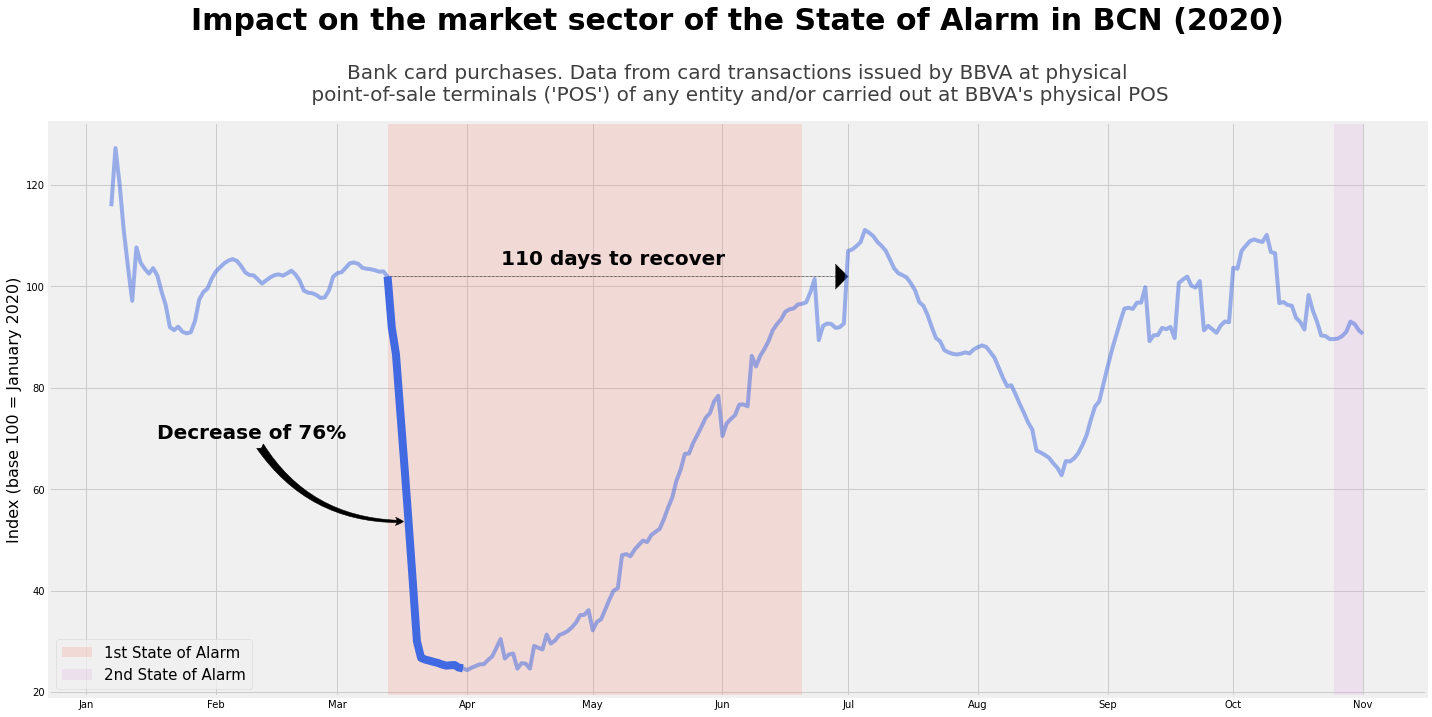

In [7]:
# plot the figure
fig, ax = plt.subplots(1, 1, figsize = (20,10))
sns.lineplot(data=s_total, alpha=0.5, color='royalblue')
plt.plot(s_min, linewidth=8, color='royalblue') # plots a thicker line

# annotations and highlightnings
note_1 = f"Decrease of {abs(decrease):.0f}%"
note_2 =f"{days_recover} days to recover"
ax.annotate(note_1, xy=(x_1, y_1), xytext=(x_2, y_2), fontsize=20, color='black',
            fontweight= 'bold',
            arrowprops=dict(
            arrowstyle='fancy',
            color='black',
            shrinkB=5,
            connectionstyle="arc3,rad=0.3",
            ))
ax.annotate(note_2, xy=(0.35, 0.63), fontsize=20, color='black',
            xycoords='figure fraction', fontweight= 'bold')
plt.arrow(y=value_1, x=start_1st_alarm, dy=0, dx=days_recover,
           color='black', linestyle=':', length_includes_head=True, head_width=5,
          head_length=3)
plt.axvspan(start_1st_alarm, final_1st_alarm, facecolor='salmon',
            alpha=0.2, label='1st State of Alarm')
plt.axvspan(start_2nd_alarm , x_3, facecolor='plum', alpha=0.2,
            label='2nd State of Alarm')

# title and subtitle
ax.text(x=0.5, y=1.15, s="Impact on the market sector of the State of Alarm in BCN (2020)",
        fontsize=30, weight='bold', ha='center', va='bottom',
        transform=ax.transAxes)
ax.text(x=0.5, y=1.03, s="Bank card purchases. Data from card transactions issued by BBVA at physical\n point-of-sale terminals ('POS') of any entity and/or carried out at BBVA's physical POS",
        fontsize=20, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

plt.xlabel('')
plt.ylabel('Index (base 100 = January 2020)', fontsize=16)

# display the month in the x-axis
locator = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(fmt)

plt.legend(fontsize=15)
plt.tight_layout()

The graph above represents a time series of bank card purchases in the city of Barcelona during the year 2020, where you can see the impact that the state of alarm has had on the market sector. The shaded areas represent the first and second state of alarms respectively.


## FIGURE 2

In [8]:
from pandas.core.common import SettingWithCopyWarning
import warnings
# ignore some annoying warnings that in this case not affect the process
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter("ignore", UserWarning)

# compute rolling mean by category
df_compres['rolling_value'] = df_compres.groupby(
    'Nom_Variable')['Valor'].transform(lambda x: x.rolling(7).mean())
df_subset = df_compres[['Data_Indicador', 'Nom_Variable', 'rolling_value']]

# assign a color to each category
cat = df_subset['Nom_Variable'].unique()
n_cat = len(cat)
line_colors = sns.color_palette('Set2', n_colors=n_cat, as_cmap=True).colors
cat_feat = {}
for x, y in zip(cat, line_colors):
  cat_feat[x] = [y]

# add to the dictionary the series of each category
for item in cat_feat:
  df_cat = df_subset.loc[(df_subset['Nom_Variable'] == item) & (
      df_subset['Data_Indicador'] >= start_1st_alarm)]
  initial_val = df_cat.iloc[0]['rolling_value']
  if (df_cat['rolling_value'] > initial_val).sum():
    date_final = df_cat.loc[df_cat['rolling_value'] > initial_val,
                            'Data_Indicador'].iloc[0]
    df_cat = df_cat.loc[df_cat['Data_Indicador'] <= date_final]
    cat_feat[item].append(df_cat)
  else:
    cat_feat[item].append(df_cat)

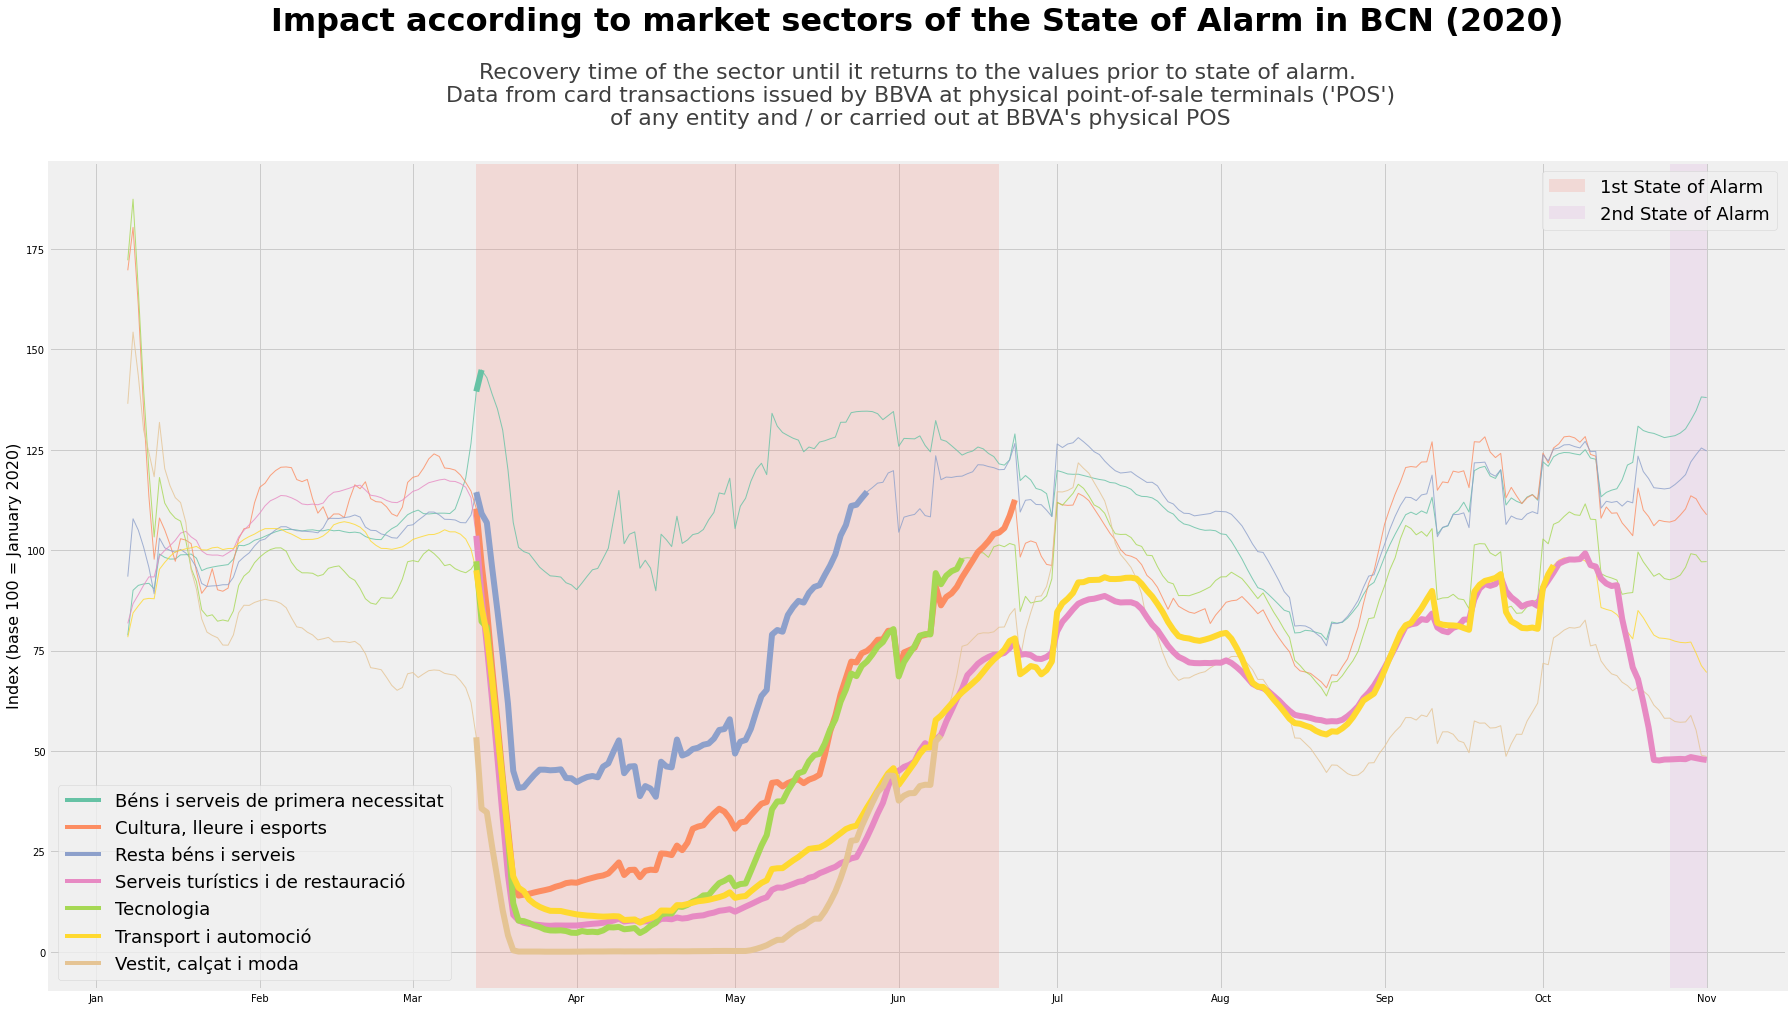

In [15]:
# plot the figure
fig, ax = plt.subplots(1, 1, figsize = (25,14))
lines = sns.lineplot(data=df_subset, x='Data_Indicador', y='rolling_value',
             hue='Nom_Variable', hue_order=cat, alpha=0.8, linewidth = 1,
             palette=line_colors)
# plot thicker lines while market sector is recovering
for item in cat_feat.values():
  line = item[1]
  plt.plot(line['Data_Indicador'], line['rolling_value'], color=item[0],
           linewidth=6) 
# shade state of alarms
span_1 = plt.axvspan(start_1st_alarm, final_1st_alarm, facecolor='salmon',
            alpha=0.2, label='1st State of Alarm')
span_2 = plt.axvspan(start_2nd_alarm , x_3, facecolor='plum', alpha=0.2,
            label='2nd State of Alarm')

# display the month in the x-axis
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(fmt)

# add two legends
leg = plt.legend(handles=lines.get_lines(), fontsize=18)
ax.add_artist(leg)
plt.legend(handles=[span_1, span_2], loc='upper right', fontsize=18)

# title and subtitle
ax.text(x=0.5, y=1.15, s="Impact according to market sectors of the State of Alarm in BCN (2020)",
        fontsize=32, weight='bold', ha='center', va='bottom',
        transform=ax.transAxes)
ax.text(x=0.5, y=1.04, s="Recovery time of the sector until it returns to the values prior to state of alarm.\n Data from card transactions issued by BBVA at physical point-of-sale terminals ('POS')\n of any entity and / or carried out at BBVA's physical POS",
        fontsize=22, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

plt.xlabel('')
plt.ylabel('Index (base 100 = January 2020)', fontsize=16)
plt.tight_layout()

The graph above represents the time series of bank card purchases according to the different market sectors. The thicker lines highlight the time it took for each sector to recover to its pre-alarm values.

## FIGURE 3

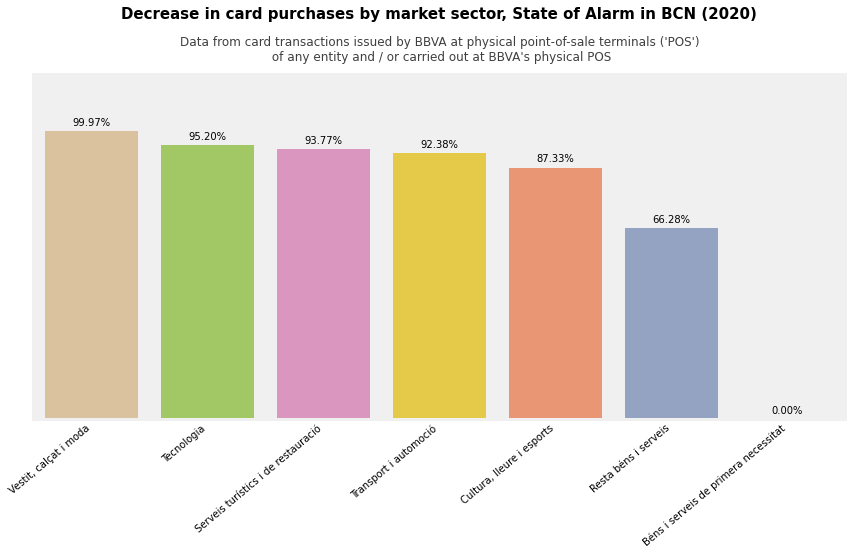

In [13]:
# compute percentatge decrease for each category
l = []
for item in cat_feat.values():
  start_val = item[1].iloc[0]['rolling_value']
  min_val = item[1].min()['rolling_value']
  change = abs(((min_val-start_val) / start_val)*100)
  l.append(change)

categories = cat_feat.keys()
df_change = pd.DataFrame({'category': categories, 'percentual_change': l})
df_change.sort_values(by='percentual_change', inplace=True, ascending=False)

# map category with color to match the plot above
map_colors = {k:v[0] for (k,v) in cat_feat.items()}

# plot the figure
fig, ax = plt.subplots(1, 1, figsize = (12,8))
sns.barplot(x='category', y='percentual_change', data=df_change, palette=map_colors)
# rotete x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

# plot the percentatges in the top of the bars
total = float(len(df_change))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 2,
            '{:1.2f}%'.format(height),
            ha="center") 

ax.get_yaxis().set_visible(False) # remove de y axis
ax.title.set_position([.5, 1.05]) # more space between title and plot
ax.set_ylim([0, 120]) 

plt.xlabel('')
plt.ylabel('Percentage (%)', fontsize=16)

# title and subtitle
ax.text(x=0.5, y=1.15, s="Decrease in card purchases by market sector, State of Alarm in BCN (2020)",
        fontsize=15, weight='bold', ha='center', va='bottom',
        transform=ax.transAxes)
ax.text(x=0.5, y=1.03, s="Data from card transactions issued by BBVA at physical point-of-sale terminals ('POS')\n of any entity and / or carried out at BBVA's physical POS",
        fontsize=12, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

plt.tight_layout()

The previous graph represents the decrease in card purchases of each market sector, calculated as the difference between the value that its associated index had on the first day of state of alarm and the minimum value reached during it.

# CONCLUSIONS

According to the data used and information that can be extracted from the different visualizations:

- Figure 1. **Card purchases decreased by 76%** and the market sector took **110 days to return to the values prior** to the state of alarm.
- Figure 2. The market sector that has taken the longest to recover, and in fact has **not yet recovered, is *'Tourism services and restaurants'***, closely followed by *'Transport and automotive'*. Others such as *'Technology'*, *'Culture, leisure and sports'* or *'Dress, footwear and fashion'*  sectors have been able to recover more quickly. On the other hand, the sector of ***'Basic goods and services'* has been little affected**, due to its very nature; indeed it can even be seen that just in the announcement of the state of alarm there is an upward peak, which represents the purchase of supplies for the quarantine.
- Figure 3. The **fashion business sector dropped almost to zero**, suffering a decrease of approximately 100%. Others sectors such as technology, restaurants and automotive were among those who suffered the most from the impact of COVID-19. 